<a href="https://colab.research.google.com/github/labgem/PANORAMA_article/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before to run Colab

Download the DATA and the source code from zenodo. Import the archive and use the next command to uncompress files.

In [ ]:
!tar -xJf DATA_notebook.tar.xz

Create a conda env

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

In [ ]:
!mamba env update -n base --file conda-env.yml -q

In [ ]:
import subprocess
import sys

# Install the package
subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/johanna-einsiedler/UpSetPlot.git@master"])

# Force Python to recognize the new package
import importlib
import sys
if 'upsetplot' in sys.modules:
    del sys.modules['upsetplot']

# Now import should work
from upsetplot import plot
import upsetplot

print("✓ upsetplot successfully installed and imported!")

# Panorama: A robust pangenome-based method for predicting and comparing biological systems across species

Jérôme Arnoux$^{1,*}$, Jean Mainguy$^{1}$, Laura Bry$^{1}$, Quentin Fernandez de Grado$^{1,2}$, Vallenet David$^{1}$, Alexandra Calteau$^{1}$,


1. LABGeM, Genomics Metabolics, CEA, Genoscope, Institut François Jacob, Université d’Évry, Université Paris-Saclay, CNRS
2. Bla

*Corresponding author*:
* jarnoux@genoscope.cns.fr

# Abstrasct

Over the last decade, the expansion in the number of available genomes has profoundly transformed the study of genetic diversity, evolution, and ecological adaptation in prokaryotes. However, traditional bioinformatic approaches based on the analysis of individual genomes are showing their limitations when faced with the sheer scale of the data. To overcome these constraints, the concept of pangenome has emerged, offering a comprehensive framework to capture the full genetic repertoire of a species. In this study, we present PANORAMA, an innovative pangenomic tool designed to exploit pangenome graphs and enable them to be annotated and compared in order to explore the genomic diversity of several species. Based on the PPanGGOLiN software suite, PANORAMA integrates advanced methods for rule-based prediction of macromolecular systems and comparative analysis of conserved features between different pangenomes, such as hotspots of insertion. We illustrate the use of PANORAMA on a Pseudomonas aeruginosa dataset, evaluating its performance against reference defense system prediction tools such as PADLOC and DefenseFinder. The analysis was then extended to a larger set including four species of Enterobacteriaceae ($>$6,000 genomes), demonstrating PANORAMA's ability to annotate, compare and explore the diversity and distribution of biological systems across multiple species. This work provides new methods for the large-scale comparative study of microbial genomes and underlines the relevance of pangenome approaches in deciphering their evolutionary dynamics. PANORAMA is freely available and accessible through: \url{https://github.com/labgem/PANORAMA}

**Keywords:**

Pangenome, Comparative genomics, Bacterial defense systems, Pseudomonas aeruginosa, Enterobacteriaceae, Bioinformatics.

# Introduction

This Jupyter notebook will be organized into three parts. The first part (Results) will generate the raw figures presented in the article. The second (Supplementary) part will generate the additional figures. The last part (DATA) will contain the commands used to create the dataset, the pangenomes, and to redo the analyses with PANORAMA. These data are also available directly in the Zenodo repository linked to the publication. It is therefore not necessary to reproduce the data.

# Results

## Define constant and load data


In [ ]:
from pathlib import Path
from multiprocessing import cpu_count

# Determine the number of available CPUs for multiprocessing
CPU_COUNT = cpu_count()
DISABLE_BAR = True
DATA = Path("DATA")
P_AERUGINOSA = DATA / "P.aeruginosa/"
PANORAMA_PADLOC_RES = P_AERUGINOSA / "PANORAMA/padloc/"
PADLOC_RES = P_AERUGINOSA / "PADLOC/"
PANORAMA_DFINDER_RES = P_AERUGINOSA / "PANORAMA/dfinder/"
DFINDER_RES = P_AERUGINOSA / "DFINDER/"
GF2GENE = P_AERUGINOSA / "gene_families.tsv"
LOCUS2PROTID = P_AERUGINOSA / "locus2protID.tsv"
SYSTEM_FILE = "systems.tsv"
OUTPUT = Path("figures")
OUTPUT.mkdir(parents=True, exist_ok=True)

In [ ]:
from multiprocessing import Process, Manager
from sources.read_results import load_gene_families, load_locus_tags

# Create a manager to coordinate shared data
manager = Manager()
return_dict = manager.dict()

# Starting the gene family and locus tag loading processes
p1 = Process(target=load_gene_families, args=(GF2GENE, return_dict, DISABLE_BAR))
p2 = Process(target=load_locus_tags, args=(LOCUS2PROTID, return_dict))

# Start and join the first two processes to ensure dependent tasks can proceed
p1.start()
p2.start()
p1.join()
p2.join()
p1.close()
p2.close()

# Retrieve necessary data from the return dictionary
gene2family = return_dict['gene2family']
locus2protID = return_dict['locus2protID']

In [ ]:
from sources.dev_utils import get_tool_systems, merge_results
from sources.read_results import load_padloc_results, load_dfinder_results, load_panorama_results, \
    read_panorama_pangenome_systems

# Starting the result loading processes (dependent on gene2family and locus2protID)
p3 = Process(target=load_padloc_results, args=(PADLOC_RES, gene2family, locus2protID, return_dict, DISABLE_BAR, 0))
p4 = Process(target=load_panorama_results, args=(PANORAMA_PADLOC_RES / "projection", return_dict, "padloc", DISABLE_BAR, 1))
p5 = Process(target=load_dfinder_results, args=(DFINDER_RES, gene2family, locus2protID, return_dict, DISABLE_BAR, 2))
p6 = Process(target=load_panorama_results, args=(PANORAMA_DFINDER_RES / "projection", return_dict, "dfinder", DISABLE_BAR, 3))

# Start the remaining processes
p3.start()
p4.start()
p5.start()
p6.start()

# Wait for all processes to complete
p3.join()
p4.join()
p5.join()
p6.join()

# Retrieving results from the shared dictionary
fam2size = return_dict['fam2size']

# Aggregating counts and annotations
count_dict = {
    "Padloc": return_dict['padloc_count'],
    "Panorama_padloc": return_dict['panorama_padloc_count'],
    "Dfinder": return_dict['dfinder_count'],
    "Panorama_dfinder": return_dict['panorama_dfinder_count']
}

fam2annot = {
    "Padloc": return_dict['padloc_fam_annot'],
    "Panorama_padloc": return_dict['panorama_padloc_fam_annot'],
    "Dfinder": return_dict['dfinder_fam_annot'],
    "Panorama_dfinder": return_dict['panorama_dfinder_fam_annot']
}

systems2partitions = {
    "Padloc": return_dict['padloc_systems2partitions'],
    "Dfinder": return_dict['dfinder_systems2partitions']
}

name2systems = {
    "Padloc": return_dict['padloc_name2systems'],
    "Dfinder": return_dict['dfinder_name2systems']
}

# Retrieve results for each method
padloc_res = return_dict['padloc_res']
dfinder_res = return_dict['dfinder_res']
panorama_padloc_res = return_dict['panorama_padloc_res']
panorama_dfinder_res = return_dict['panorama_dfinder_res']

# Extract systems from PADLOC and DefenseFinder
padloc_systems = get_tool_systems(padloc_res)
dfinder_systems = get_tool_systems(dfinder_res)

# Extract systems from the panorama dictionaries
panorama_systems_padloc = read_panorama_pangenome_systems(PANORAMA_PADLOC_RES / SYSTEM_FILE)
panorama_systems_dfinder = read_panorama_pangenome_systems(PANORAMA_DFINDER_RES / SYSTEM_FILE)
# Combine the panorama systems
dfinder_systems = merge_results(dfinder_systems, dfinder_systems, 1)
padloc_systems = merge_results(padloc_systems, padloc_systems, 1)
panorama_systems = merge_results(panorama_systems_padloc, panorama_systems_dfinder, 1)

## System prediction benchmark

In [ ]:
from IPython.display import display
import pandas as pd
from sources.boxplot import gen_boxplot_pangenome
from sources.venn import plot_venn_diagram, count_system_similar
from sources.score import compute_score_pangenome, compute_score_organisms

P_AERUGINOSA_OUTPUT = OUTPUT / "P.aeruginosa"
P_AERUGINOSA_OUTPUT.mkdir(parents=True, exist_ok=True)

gen_boxplot_pangenome(padloc=padloc_systems, dfinder=dfinder_systems,
                      panorama=panorama_systems, output=P_AERUGINOSA_OUTPUT / "boxplot_venn.png")
plot_venn_diagram(padloc_systems, dfinder_systems, panorama_systems, P_AERUGINOSA_OUTPUT)

count_similar = count_system_similar(padloc_systems, dfinder_systems, panorama_systems_padloc,
                                     panorama_systems_dfinder, P_AERUGINOSA_OUTPUT, 1)
display(count_similar)
THRESHOLD = 0.5
scores = {"Pangenome": {"PADLOC": {},
                        "DFinder": {}},
          "Organisms": {"PADLOC": {},
                        "DFinder": {}}
          }
recall, precision, f1_score = compute_score_pangenome(panorama_systems_padloc, padloc_systems, 'PADLOC',
                                                      P_AERUGINOSA_OUTPUT, THRESHOLD)
scores["Pangenome"]["PADLOC"] = {"Recall": recall, "Precision": precision, "F1-Score": f1_score}

recall, precision, f1_score = compute_score_pangenome(panorama_systems_dfinder, dfinder_systems, 'Defense_Finder',
                                                      P_AERUGINOSA_OUTPUT, THRESHOLD)
scores["Pangenome"]["DFinder"] = {"Recall": recall, "Precision": precision, "F1-Score": f1_score}

recall, precision, f1_score = compute_score_organisms(panorama_padloc_res, padloc_res, 'PADLOC', P_AERUGINOSA_OUTPUT,
                                                      THRESHOLD)
scores["Organisms"]["PADLOC"] = {"Recall": recall, "Precision": precision, "F1-Score": f1_score}

recall, precision, f1_score = compute_score_organisms(panorama_dfinder_res, dfinder_res, 'Defense_Finder',
                                                      P_AERUGINOSA_OUTPUT,
                                                      THRESHOLD)
scores["Organisms"]["DFinder"] = {"Recall": recall, "Precision": precision, "F1-Score": f1_score}

# Convert scores dictionary to DataFrame
scores_list = []
for category, tools in scores.items():
    for tool, metrics in tools.items():
        scores_list.append({
            "Category": category,
            "Tool": tool,
            "Recall": metrics["Recall"],
            "Precision": metrics["Precision"],
            "F1-Score": metrics["F1-Score"]
        })

scores_df = pd.DataFrame(scores_list)
display(scores_df)

 **Fig. 2. Comparison of PANORAMA, PADLOC, and DefenseFinder system predictions at the pangenome
level.** PADLOC and Defense Finder predictions at the genome level were unified at the pangenome level by converting sets
of system genes to sets of gene families. (A) Venn diagram illustrating the overlap of system families predicted by the three
tools. (B) Boxplots displaying the distribution of system counts for each category, as predicted by the different tools.

## *Pseudomonas aeruginosa* defense system analysis

### System prediction and analysis

In [ ]:
import pandas as pd
from sources.dev_utils import type2category
from sources.system_analyses import plot_occurrences_and_fraction

MODELS = DATA / "Models/defense-finder/models_list.tsv"
RESULTS = PANORAMA_DFINDER_RES / 'systems.tsv'
NB_GROUP = 20
NB_COLS = 55
NB_SPOTS = 7
FIGSIZE = (40, 20)
REVERSE = False
BAR_COLORS = ("darkblue", "darkgreen", "darkorange")

systems_data = pd.read_csv(RESULTS, sep='\t',
                           usecols=["system number", "system name", "organism",
                                    "model_GF", "partition", "spots"])

# Add the system category grouping
systems_data['system category'] = systems_data['system name'].map(type2category)
systems_data.to_csv(OUTPUT / "sys_tmp.tsv", sep="\t", index=False)
plot_occurrences_and_fraction(systems_data, MODELS, NB_GROUP, field='system category', output=P_AERUGINOSA_OUTPUT,
                              kind="bar", reverse=REVERSE, bar_colors=BAR_COLORS)

**Fig. 3. System prediction metrics in *P. aeruginosa*.** Systems are grouped by categories on the x-axis and ordered
by decreasing values. Only the 19 highest-value system categories are displayed, with others grouped under the "Other"
category. (A) Number of systems found for each category in the pangenome. (B) Relative frequency of system categories in
genomes. (C) Shannon entropy of system categories.

### Defense islands and spots of insertion

In [ ]:
from sources.hotspot import get_spot2orgs, get_data_projection, scatter_plot

projection = PANORAMA_DFINDER_RES / "projection"
tables = P_AERUGINOSA / 'table'

number_genomes = sum(1 for _ in tables.glob("*.tsv"))
spot_to_orgs = get_spot2orgs(tables, DISABLE_BAR, 0)
proj_df = get_data_projection(projection, DISABLE_BAR, 1)

proj_df.to_csv(P_AERUGINOSA_OUTPUT / "spot2sys_genomes.tsv", sep="\t", index=True)
scatter_plot(proj_df, spot_to_orgs, number_genomes, P_AERUGINOSA_OUTPUT, file_name="defense_hotspot_aeruginosa",
             min_freq=.25, min_sys=60)


**Fig. 4. System diversity and defense spot frequency in *P. aeruginosa*.** This bubble plot displays the distribution
of defense spots identified by PANORAMA, based on their frequency in genomes (x-axis) and the total number of defense
systems identified within each spot at the pangenome level (y-axis). The size of the bubbles is proportional to the number
of distinct system categories represented in each spot (legend at the top shows scale).

In [ ]:
from sources.system_analyses import plot_spots_and_pies

plot_spots_and_pies(proj_df, systems_data, field='system category', nb_cols=NB_COLS,
                    nb_spots=NB_SPOTS, output=P_AERUGINOSA_OUTPUT, figsize=FIGSIZE)

**Fig. 5. Defense systems within insertion spots of the *P. aeruginosa* pangenome.** The bar plot (top) displays the
number of predicted defense systems in the P. aeruginosa pangenome for each insertion spot. Only spots with at least 10
systems are displayed. The pie charts (bottom) illustrate the system category composition for the six major insertion spots.

## Pangenome comparison of Enterobacteriaceae defense arsenal

### Get results and define constant

In [ ]:
# Determine the number of available CPUs for multiprocessing
ENTEROBACTERIACEAE = DATA / "Enterobacteriaceae/"
ENTEROBACTERIACEAE_OUTPUT = OUTPUT / "Enterobacteriaceae"
ENTEROBACTERIACEAE_OUTPUT.mkdir(parents=True, exist_ok=True)
C_FREUNDII = ENTEROBACTERIACEAE / "C.freundii/dfinder"
C_FREUNDII_OUTPUT = ENTEROBACTERIACEAE_OUTPUT / "C.freundii"
C_FREUNDII_OUTPUT.mkdir(parents=True, exist_ok=True)
E_COLI = ENTEROBACTERIACEAE / "E.coli/dfinder"
E_COLI_OUTPUT = ENTEROBACTERIACEAE_OUTPUT / "E.coli"
E_COLI_OUTPUT.mkdir(parents=True, exist_ok=True)
K_PNEUMONIAE = ENTEROBACTERIACEAE / "K.pneumoniae/dfinder"
K_PNEUMONIAE_OUTPUT = ENTEROBACTERIACEAE_OUTPUT / "K.pneumoniae"
K_PNEUMONIAE_OUTPUT.mkdir(parents=True, exist_ok=True)
S_ENTERICA = ENTEROBACTERIACEAE / "S.enterica/dfinder"
S_ENTERICA_OUTPUT = ENTEROBACTERIACEAE_OUTPUT / "S.enterica"
S_ENTERICA_OUTPUT.mkdir(parents=True, exist_ok=True)

### Defense system distribution in the four species

In [ ]:
from sources.heatmap import load_system_data, generate_heatmap

heatmap_data = load_system_data(ENTEROBACTERIACEAE)
params = {
    'linecolor': 'lightgray',
    'linewidths': 1,
    "cmap": 'rocket_r',
    "xticklabels": True,
    "yticklabels": True
}

# Generate a heatmap for normalized system frequencies without RM
heatmap_data_normalized = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100
heatmap_data_normalized_no_rm = heatmap_data_normalized.drop(index="RM")
generate_heatmap(
    heatmap_data_normalized_no_rm,
    ENTEROBACTERIACEAE_OUTPUT / "heatmap_normalized_sys_no_RM.png",
    figsize=FIGSIZE,
    cbar_label="System frequency",
    annot=True,
    fmt=".1f",
    rotation=90,
    **params
)


**Fig. 6. Relative frequency of system categories in Enterobacteriaceae pangenomes.** The relative frequencies are expressed as a percentage. The RM system category was removed to get a clearer view.

### Identification of conserved spots

In [ ]:
from sources.upset_plot import parse_data, generate_upset_plot_spots
from matplotlib import legend as mlegend

# Fix a bug from upsetplot
original_legend_init = mlegend.Legend.__init__

def patched_legend_init(self, parent, handles, labels, *args, **kwargs):
    """
    Modifies the initialization of a legend object to ensure that the provided
    handles and labels, if they have a reversible data type, are explicitly
    converted into lists before proceeding to the original constructor. This can
    help prevent issues caused by specific data structures being used for
    handles or labels.

    Args:
        self: The instance of the legend being initialized.
        parent: The parent object containing the legend.
        handles: A collection of artist handles that will be represented in the
            legend.
        labels: A collection of labels corresponding to the handles.
        *args: Additional positional arguments passed to the legend object.
        **kwargs: Additional keyword arguments passed to the legend object.
    """
    if hasattr(handles, '__reversed__'):
        handles = list(handles)
    if hasattr(labels, '__reversed__'):
        labels = list(labels)

    original_legend_init(self, parent, handles, labels, *args, **kwargs)

mlegend.Legend.__init__ = patched_legend_init

# Example usage
cs_res = pd.read_csv(ENTEROBACTERIACEAE / "all_conserved_spots.tsv", sep="\t",
                     usecols=["Conserved_Spot_ID", "Spot_ID", "Pangenome"])

spots_data = {
    'C.freundii': 254,
    'E.coli': 2036,
    'K.pneumoniae': 778,
    'S.enterica': 458
}

systems_data = {
    'C.freundii': pd.read_csv(C_FREUNDII / SYSTEM_FILE, sep="\t"),
    'E.coli': pd.read_csv(E_COLI / SYSTEM_FILE, sep="\t"),
    'K.pneumoniae': pd.read_csv(K_PNEUMONIAE / SYSTEM_FILE, sep="\t"),
    'S.enterica': pd.read_csv(S_ENTERICA / SYSTEM_FILE, sep="\t")
}

parsed_data = parse_data(cs_res, systems_data, spots_data)
parsed_data.to_csv(ENTEROBACTERIACEAE_OUTPUT / "upset_data.tsv", sep="\t", index=False)
generate_upset_plot_spots(parsed_data, list(systems_data.keys()), ENTEROBACTERIACEAE_OUTPUT)



**Fig. 7. Sharing of spot clusters across four species and their association with defense systems.** The UpSet plot shows the number of spot clusters shared across the four compared species, with stacked bars to indicate whether they contain defense systems (in blue) or not (in orange). The two top bar plots represent spot and defense system abundance metrics on a logarithmic scale.

### Spot identification and conservation

In [ ]:
from sources.cs_link import parse_data, generate_tile_plot_visualization

results = pd.read_csv(ENTEROBACTERIACEAE / "all_conserved_spots.tsv", sep="\t",
                      usecols=["Conserved_Spot_ID", "Spot_ID", "Pangenome"])

systems_data = {
    'C.freundii': pd.read_csv(C_FREUNDII / SYSTEM_FILE, sep="\t"),
    'E.coli': pd.read_csv(E_COLI / SYSTEM_FILE, sep="\t"),
    'K.pneumoniae': pd.read_csv(K_PNEUMONIAE / SYSTEM_FILE, sep="\t"),
    'S.enterica': pd.read_csv(S_ENTERICA / SYSTEM_FILE, sep="\t")
}

data = parse_data(results, systems=systems_data)
data.to_csv(ENTEROBACTERIACEAE_OUTPUT / "cs_link.tsv", sep="\t", index=True)
generate_tile_plot_visualization(data, ENTEROBACTERIACEAE_OUTPUT)


**Fig. 8. Relative frequency of system categories in each spot cluster.** The heatmap presents the relative frequency
(%) of system categories per spot cluster. Species associated with each spot cluster are listed next to the cluster identifiers.

# Supplementary


**Fig. S1. Number of Systems Predicted for Each Model in Enterobacteriaceae Pangenomes.** PANORAMA automatically generates this figure. PANORAMA employs the Bokeh package to create interactive and dynamic visualizations, which can be directly accessed and manipulated in any standard web browser.

In [ ]:
# N.B: You must launch the cell that generates the figure 6

# Calculate and plot system specificity
col_sums = heatmap_data.sum(axis=0).to_numpy()  # Sum by species (columns)
row_sums = heatmap_data.sum(axis=1).to_numpy()  # Sum by system (rows)
total_sum = heatmap_data.values.sum()  # Total sum

# Calculate specificity metric
specificity_data = (heatmap_data.div(col_sums, axis=1)) / (row_sums / total_sum)[:, None]
generate_heatmap(
    specificity_data.T,
    ENTEROBACTERIACEAE_OUTPUT / "heatmap_system_distribution.png",
    figsize=(15, 35),
    cbar_label="Specificity",
    annot=True,
    fmt=".1f",
    **params
)

**Fig. S2. Species-specificity evaluation across system categories in Enterobacteriaceae Pangenomes.** The
enrichment factors were computed using the method described in Equation 6, providing a quantitative measure of species-specific representation.

In [ ]:
import matplotlib.pyplot as plt
from sources.dev_utils import type2category
from sources.system_analyses import get_pie_charts_info, plot_pie, create_color_map, spot_occurrence, \
    plot_spot_occurrence, parse_data


def plot_spot_systems(proj_data: pd.DataFrame, sys_data: pd.DataFrame, output: Path):
    """
    Generate a plot with occurrences in spots and pie charts for the top spots.

    Args:
        proj_data (pd.DataFrame): DataFrame containing the projection data.
        sys_data (pd.DataFrame): DataFrame containing the system data.
        output (Path): Path to save the output plots.

    Returns:
        None
    """
    nb_slice = 10
    nb_top_occ = 24
    field = 'system category'
    # Get spot occurrences and top types
    data_df = parse_data(proj_data, sys_data)
    spot_grouped_type_counts, top_types_occ = spot_occurrence(data_df, output, field=field, nb_cols=20,
                                                              nb_top=nb_top_occ, keep_other_spots=False)

    # Get pie chart information
    top_types_pie, top_spots, spot_type_counts = get_pie_charts_info(data_df, field, 5, nb_slice)

    # Create a consistent color map for system types
    color_map = create_color_map(top_types_occ | top_types_pie)

    # Plot and save bar plot for spot occurrences
    nb_col_legend = len(top_types_occ) // 10 + 1
    fig, ax = plt.subplots(figsize=FIGSIZE)
    plot_spot_occurrence(spot_grouped_type_counts, color_map, nb_color_legend=nb_col_legend, ax=ax)
    ax.set_title("Occurrences in spots", fontsize=20)
    plt.tight_layout()
    plt.savefig(output / "spots_sys_distri.png", bbox_inches="tight", dpi=300)


def draw_pie_chart(sys_data: pd.DataFrame, spot_id: int, output: Path, fig_name: str):
    """
    Generates and saves a pie chart visualization based on the specified spot data. The method uses
    the system data and a specific spot identifier to create color mappings and plot a pie chart
    visualizing a breakdown of the spot type counts. The figure is saved in both PNG and SVG formats
    with high resolution.

    Args:
        sys_data: A pandas DataFrame containing the system data to be aggregated and visualized.
        spot_id: An integer representing the unique identifier of the spot for which the pie chart
                is being generated.
        output: A Path object representing the directory where the figure will be saved.
        fig_name: A string representing the name of the figure to be saved. The name should include

    Returns:
         None
    """
    top_types_pie, _, spot_type_counts = get_pie_charts_info(sys_data, field="system category", nb_spots=6,
                                                             nb_slice=10, top_spots=[str(spot_id)])
    color_map = create_color_map(top_types_pie)
    spot_data = spot_type_counts.loc[str(spot_id)].drop('total')
    fig, ax = plt.subplots(figsize=(8, 12))
    plot_pie(spot_data, color_map, ax, 10, base_fontsize=24)
    plt.tight_layout()
    plt.savefig(output / f"{fig_name}.png", format='png', dpi=300)
    plt.savefig(output / f"{fig_name}.svg", format='svg')


In [ ]:
projection = S_ENTERICA / "projection"
proj_df = get_data_projection(projection, DISABLE_BAR, 0)

In [ ]:
s_enterica_systems = pd.read_csv(S_ENTERICA / SYSTEM_FILE, sep="\t")
s_enterica_systems["system category"] = s_enterica_systems["system name"].map(type2category)
plot_spot_systems(proj_df, s_enterica_systems, output=S_ENTERICA_OUTPUT)
draw_pie_chart(s_enterica_systems, 86, S_ENTERICA_OUTPUT, "spots_86_enterica")

In [ ]:
projection = E_COLI / "projection"
proj_df = get_data_projection(projection, DISABLE_BAR, 0)

In [ ]:
e_coli_systems = pd.read_csv(E_COLI / SYSTEM_FILE, sep="\t")
e_coli_systems["system category"] = e_coli_systems["system name"].map(type2category)
plot_spot_systems(proj_df, e_coli_systems, output=E_COLI_OUTPUT)
draw_pie_chart(e_coli_systems, 175, E_COLI_OUTPUT, "spots_175_coli")

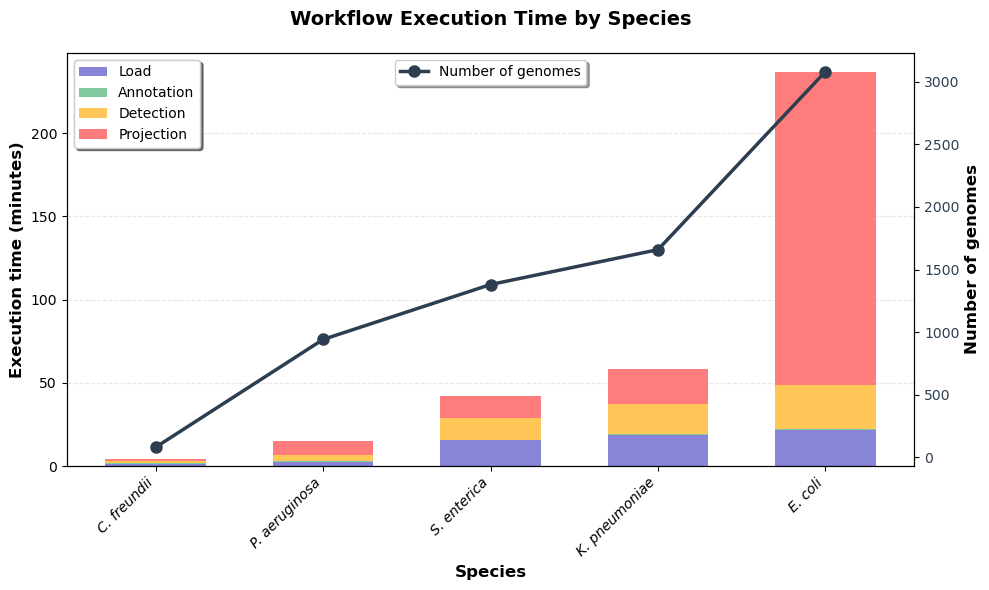

In [2]:
from sources.workflowtime import plot_workflowtime, time_to_minutes
# Data
species2genomes = {
    'C. freundii': 79,
    'P. aeruginosa': 941,
    'S. enterica': 1380,
    'K. pneumoniae': 1659,
    'E. coli': 3083
}

# Time data
load = [time_to_minutes(time_str=t) for t in
        ['01:22.18', '02:33.70', '15:38.76', '18:51.78', '21:36.71']]
annotation = [time_to_minutes(time_str=t) for t in
              ['00:09.07', '00:20.60', '00:12.10', '00:17.69', '00:26.32']]
detection = [time_to_minutes(time_str=t) for t in
             ['01:32.47', '03:47.50', '13:06.14', '18:15.45', '26:26.29']]
projection = [time_to_minutes(time_str=t) for t in
              ['01:17.98', '08:22.23', '13:09.22', '21:04.96', '188:02.75']]

# Build species2times dictionary
species2times = {}
for idx, sp in enumerate(species2genomes.keys()):
    species2times[sp] = {
        'load': load[idx],
        'annotation': annotation[idx],
        'detection': detection[idx],
        'projection': projection[idx]
    }

from pathlib import Path
OUTPUT = Path("figures")
plot_workflowtime(species2times, species2genomes, OUTPUT)

# DATA

## Where to find the information

In the zenodo, you can find either the genomes' assembly summary for each species or the pangenome already computed. This way you can start from genomes or pangenomes.

## Create Conda environments
In this part we suggest creating new conda environments to prevent any incompatibility.

### PANORAMA

To install PPanGGOLiN & PANORAMA proceed as such:

```shell
# Create a new Conda environment and install PPanGGOLiN
conda create -n panorama -c conda-forge -c bioconda panorama

# Activate the environment
conda activate panorama

# Verify the installation
ppanggolin --version
panorama --version

# Install also genome_updater to download genomes
conda install -c bioconda genome_updater
conda deactivate
```

### PADLOC

Install PADLOC such as:
```shell
# Install PADLOC into a new conda environment
conda create -n padloc -c conda-forge -c bioconda -c padlocbio padloc==2.0.0
# Activate the environment
conda activate padloc
# Install hmmer
conda install -c bioconda hmmer
# Download the latest database
padloc --db-update
```

### DefenseFinder

Install DefenseFinder such as:
```shell
conda create -n defensefinder
conda activate defensefinder
pip install mdmparis-defense-finder==1.2.2
conda install hmmer
defense-finder update
```

## P.aeruginosa
### Download genomes

```shell
conda activate panorama
cd DATA/P.aeruginosa
mkdir Genomes
genome_updater.sh -M gtdb -e assembly_summary.txt -f 'genomic.fna.gz, assembly_report.txt, protein.faa.gz,  genomic.gff.gz, translated_cds.faa.gz' -o Genomes -t 20
```
### Generate the pangenome

```shell
cd DATA/P.aeruginosa
mkdir Pangenome
if [ -f "Pangenome/P.aeruginosa_gff.list" ]; then
    rm "Pangenome/P.aeruginosa_gff.list"
fi
if [ -f "Pangenome/P.aeruginosa_fna.list" ]; then
    rm "Pangenome/P.aeruginosa_fna.list"
fi
for gff in Genomes/*/files/*gff*; do fna=$(echo $gff | sed 's/gff/fna/'); org=$(echo $gff | cut -d'/' -f4 | sed 's/_genomic.gff.gz//'); echo $org    $(pwd)/$gff >>Pangenome/P.aeruginosa_gff.list; echo $org    $(pwd)/$fna >> Pangenome/P.aeruginosa_fna.list; done
sed -i 's/\s\s*/\t/' Pangenome/P.aeruginosa_*
ppanggolin all --anno Pangenome/P.aeruginosa_gff.list --fasta Pangenome/P.aeruginosa_fna.list --no_flat_files --cpu 20 -o Pangenome -f
```

### Prediction with PADLOC

First, we need to uncompress the genomes as PADLOC does not read compressed files.

```shell
conda activate padloc
cd DATA/P.aeruginosa
mkdir -p PADLOC/tmp_genomes/GFF
for gff in Genomes/*/files/*gff*; do name=$(basename "$gff" .gz); gunzip -c $gff > PADLOC/tmp_genomes/GFF/$name; done
mkdir -p PADLOC/tmp_genomes/FAA
for faa in Genomes/*/files/*_protein.faa*; do name=$(basename "$faa" .gz); gunzip -c $faa > PADLOC/tmp_genomes/FAA/$name; done
cd ..
```

PADLOC introduces "other" models that are not corresponding to an existing model. In our analyses we removed this model.

```shell
git clone https://github.com/padlocbio/padloc-db.git
cd padloc-db/sys
rm *other* cas_adaptation.yaml
cd ..
cp sys_meta.txt sys_meta_original.txt
grep -v other sys_meta_original.txt | grep -v cas_adaptation > sys_meta.txt
cd ..
```

now we can launch the prediction

```shell
cd DATA/P.aeruginosa/PADLOC
mkdir Analysis
for gff in tmp_genomes/GFF/*; do org=$(echo $gff | cut -d'/' -f1,2,5 | sed 's/_genomic.gff//'); faa=$(echo $gff | sed 's/GFF/FAA/' |sed 's/_genomic.gff/_protein.faa/'); mkdir Analysis/$org; echo padloc --gff $gff --faa $faa --cpu 1 -o Analysis/$org --data ../../padloc-db; done
```

(Optional) You can delete the uncompressed genome files, such as:
```shell
rm -rf tmp_genomes/*
```

### Prediction with Defense Finder
First, we need to uncompress the translated CDS in order to have similar sequences between tools.

```shell
cd DATA/P.aeruginosa
mkdir -p DFinder/tmp_genomes/TransCDS
for faa in Genomes/*/files/*translated*;do name=$(basename "$faa" .gz); gunzip -c $faa | awk '/^>/ {if (skip) skip=0; if (/pseudo=true/) skip=1} !skip' > DFinder/tmp_genomes/TransCDS/$name; done
```

DefenseFinder introduce canonical model for CRISPRCas systems. In our analyses we removed these models.

```shell
cd DATA
mkdir DFinderDB
cp -r ~/.macsyfinder/models/CasFinder DFinderDB/.
cp -r ~/.macsyfinder/models/defense-finder-models DFinderDB/
rm DFinderDB/CasFinder/definitions/CAS_Cluster.xml
```

now we can launch the prediction

```shell
conda activate defensefinder
cd DATA/P.aeruginosa/DFinder/
mkdir Analysis
for faa in tmp_genomes/TransCDS/*.faa;do name=$(echo $faa | cut -d'/' -f7 | sed 's/_translated_cds.faa//'); mkdir Analysis/$name; echo defense-finder run -o $name -w 1 $faa --models-dir ../../DFinderDB ; done > defense_finder.cmd
```

(Optional) You can delete the uncompressed genome files, such as:
```shell
rm -rf P.aeruginosa/DFinder/tmp_genomes/*
```

### Prediction with PANORAMA

First, you need to download the models.

<!--Partie à réaliser lorsque les modèles seront mis à disposition-->

Now you can predict the systems with PANORAMA

```shell
conda activate panorama
cd DATA/P.aeruginosa
mkdir -p PANORAMA/Analysis
cd PANORAMA/Analysis
echo "P.aeruginosa	../../Pangenome/pangenome.h5" > pangenomes.tsv
panorama pansystems -p pangenomes.tsv -s padloc --hmm ../../../Models/padloc/hmm_list.tsv --models ../../../Models/padloc/models_list.tsv -o . --projection --association all --threads 1 --force

panorama pansystems -p pangenomes.tsv -s defensefinder --hmm ../../../Models/defense-finder/hmm_list.tsv --models ../../../Models/defense-finder/models_list.tsv -o . --projection --association all --threads 1 --force
```

## Enterobacteriaceae

### Download Genomes

```shell
conda activate panorama
cd DATA/Enterobacteriaceae
mkdir Genomes
mkdir Genomes/C.freundii
genome_updater.sh -M gtdb -e assembly_summary_c_freundii.txt -f 'genomic.gbff.gz' -o Genomes/C.freundii -t 1
mkdir Genomes/E.coli
genome_updater.sh -M gtdb -e assembly_summary_e_coli.txt -f 'genomic.gbff.gz' -o Genomes/E.coli -t 1
mkdir Genomes/K.pneumoniae
genome_updater.sh -M gtdb -e assembly_summary_k_pneumoniae.txt -f 'genomic.gbff.gz' -o Genomes/K.pneumoniae -t 1
mkdir Genomes/S.enterica
genome_updater.sh -M gtdb -e assembly_summary_s_enterica.txt -f 'genomic.gbff.gz' -o Genomes/S_enterica -t 1
```
### Generate the pangenomes

First we generate the input files for PPanGGOLiN.

```shell
for gbff in Genomes/C.Freundii/2024-07-09_19-21-03/files/*gbff*; do org=$(echo $gbff | cut -d'/' -f5 | sed 's/_genomic.gbff.gz//'); echo $org $(pwd)/$gbff; done > Pangenomes/C.Freundii_gbff.list; sed -i 's/\s\s*/\t/' Pangenomes/C.Freundii_gbff.list
for gbff in Genomes/E.Coli/2024-07-09_19-20-03/files/*gbff*; do org=$(echo $gbff | cut -d'/' -f5 | sed 's/_genomic.gbff.gz//'); echo $org      $(pwd)/$gbff; done > Pangenomes/E.coli_gbff.list; sed -i 's/\s\s*/\t/' Pangenomes/E.coli_gbff.list
for gbff in Genomes/K.pneumoniae/2024-07-09_19-22-03/files/*gbff*; do org=$(echo $gbff | cut -d'/' -f5 | sed 's/_genomic.gbff.gz//'); echo $org       $(pwd)/$gbff; done > Pangenomes/K.pneumoniae_gbff.list; sed -i 's/\s\s*/\t/' Pangenomes/K.pneumoniae_gbff.list
for gbff in Genomes/S.Enterica/2024-07-09_19-24-34/files/*gbff*; do org=$(echo $gbff | cut -d'/' -f5 | sed 's/_genomic.gbff.gz//'); echo $org $(pwd)/$gbff; done > Pangenomes/S.Enterica_gbff.list; sed -i 's/\s\s*/\t/' Pangenomes/S.Enterica_gbff.list
```

We can now generate pangenomes
```shell
cd Pangenomes
ppanggolin all --anno C.Freundii_gbff.list --no_flat_files --cpu 36 -o C.freundii -f
ppanggolin all --anno E.coli_gbff.list --no_flat_files --cpu 1 -o E.coli -f
ppanggolin all --anno K.pneumoniae_gbff.list --no_flat_files --cpu 1 -o K.pneumoniae -f
ppanggolin all --anno S.Enterica_gbff.list --no_flat_files --cpu 1 -o S.Enterica -f
cd ..
```

### Run the analysis with PANORAMA

We will run the analysis with the translated defense finder models, previously used for *P.aeruginosa*

```shell
mkdir Analyses
cd Analyses
echo "C.freundii	Pangenomes/C.freundii/pangenome.h5" > pangenomes.tsv
echo "E.coli	Pangenomes/E.coli/pangenome.h5" >> pangenomes.tsv
echo "K.pneumoniae	Pangenomes/K.pneumoniae/pangenome.h5" >> pangenomes.tsv
echo "S.enterica	Pangenomes/S.enterica/pangenome.h5" >> pangenomes.tsv
panorama pansystems -p pangenomes.tsv -s dfinder --hmm ../../Models/defense-finder/hmm_list.tsv --models ../../Models/defense-finder/models_list.tsv -o . --projection --association all --threads 1 --force
```

## Run the Jupyter Notebook

You now have all the results. You can rerun the notebook to get the figures.